In [92]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.0501,
	"longitude": -114.0853,
	"start_date": "2021-01-01",
	"end_date": "2024-12-31",
	"hourly": "soil_temperature_0_to_7cm",
	"daily": ["temperature_2m_mean", "daylight_duration", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_soil_temperature_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(3).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 51.07205581665039°N -114.03227233886719°E
Elevation 1043.0 m asl
Timezone b'America/Edmonton' b'GMT-7'
Timezone difference to GMT+0 -25200 s
                           date  soil_temperature_0_to_7cm
0     2021-01-01 07:00:00+00:00                     -1.251
1     2021-01-01 08:00:00+00:00                     -1.251
2     2021-01-01 09:00:00+00:00                     -1.251
3     2021-01-01 10:00:00+00:00                     -1.251
4     2021-01-01 11:00:00+00:00                     -1.251
...                         ...                        ...
35059 2025-01-01 02:00:00+00:00                     -6.401
35060 2025-01-01 03:00:00+00:00                     -6.601
35061 2025-01-01 04:00:00+00:00                     -6.751
35062 2025-01-01 05:00:00+00:00                     -6.951
35063 2025-01-01 06:00:00+00:00                     -7.251

[35064 rows x 2 columns]
                          date  temperature_2m_mean  daylight_duration  \
0    2021-01-01 07:00:00+00:00         

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams["figure.figsize"] = (10,5)
df = daily_dataframe.set_index("date")
df.head()

,temperature_2m_mean,daylight_duration,rain_sum,snowfall_sum,wind_speed_10m_max,shortwave_radiation_sum
date,,,,,,
2021-01-01 07:00:00+00:00,-3.040584,28854.302734,0.0,0.0,18.581022,3.72
2021-01-02 07:00:00+00:00,0.034417,28927.406250,0.0,0.0,39.127541,4.49
2021-01-03 07:00:00+00:00,0.474000,29005.925781,0.1,0.0,34.949680,4.91
2021-01-04 07:00:00+00:00,-2.207250,29089.761719,0.0,0.0,24.522316,4.36
2021-01-05 07:00:00+00:00,-0.444750,29178.787109,0.0,0.7,16.595179,4.93


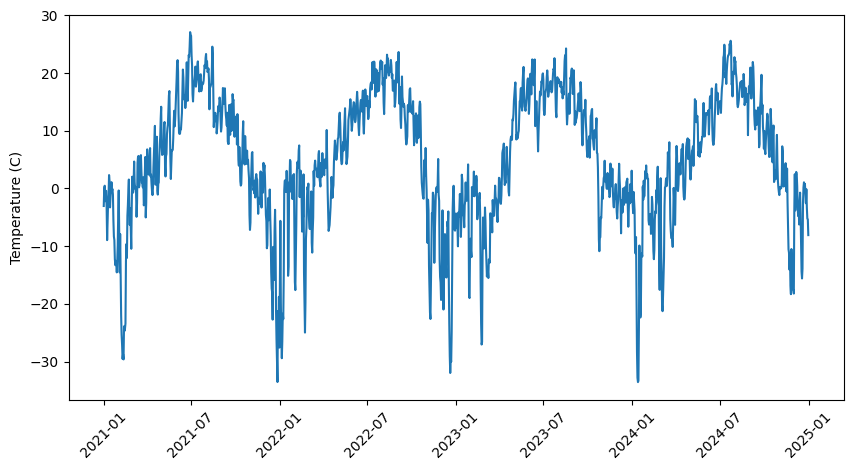

In [137]:
plt.plot(df["temperature_2m_mean"])
plt.ylabel("Temperature (C)")
plt.xticks(rotation = 45)
plt.show()

In [138]:
lags = 3  # Using past 3 days' data
for col in df.columns:
    for lag in range(1, lags + 1):
        df[f"{col}_Lag{lag}"] = df[col].shift(lag)

# Moving Average Features
df["Temp_MA_3"] = df["temperature_2m_mean"].rolling(window=3).mean()
df.dropna(inplace=True)

df.head()

,temperature_2m_mean,daylight_duration,rain_sum,snowfall_sum,wind_speed_10m_max,shortwave_radiation_sum,temperature_2m_mean_Lag1,temperature_2m_mean_Lag2,temperature_2m_mean_Lag3,daylight_duration_Lag1,...,snowfall_sum_Lag1,snowfall_sum_Lag2,snowfall_sum_Lag3,wind_speed_10m_max_Lag1,wind_speed_10m_max_Lag2,wind_speed_10m_max_Lag3,shortwave_radiation_sum_Lag1,shortwave_radiation_sum_Lag2,shortwave_radiation_sum_Lag3,Temp_MA_3
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 07:00:00+00:00,-2.207250,29089.761719,0.0,0.0,24.522316,4.36,0.474000,0.034417,-3.040584,29005.925781,...,0.0,0.0,0.0,34.949680,39.127541,18.581022,4.91,4.49,3.72,-0.566278
2021-01-05 07:00:00+00:00,-0.444750,29178.787109,0.0,0.7,16.595179,4.93,-2.207250,0.474000,0.034417,29089.761719,...,0.0,0.0,0.0,24.522316,34.949680,39.127541,4.36,4.91,4.49,-0.726000
2021-01-06 07:00:00+00:00,-0.415583,29272.900391,0.0,0.0,16.099689,3.54,-0.444750,-2.207250,0.474000,29178.787109,...,0.7,0.0,0.0,16.595179,24.522316,34.949680,4.93,4.36,4.91,-1.022528
2021-01-07 07:00:00+00:00,-3.432250,29371.976562,0.0,0.0,14.578888,5.13,-0.415583,-0.444750,-2.207250,29272.900391,...,0.0,0.7,0.0,16.099689,16.595179,24.522316,3.54,4.93,4.36,-1.430861
2021-01-08 07:00:00+00:00,-8.955167,29476.453125,0.0,0.0,14.332340,5.39,-3.432250,-0.415583,-0.444750,29371.976562,...,0.0,0.0,0.7,14.578888,16.099689,16.595179,5.13,3.54,4.93,-4.267667


In [139]:
y = df["temperature_2m_mean"]
X = df.drop("temperature_2m_mean", axis = 'columns')
print(daily_dataframe["temperature_2m_mean"].max(),daily_dataframe["temperature_2m_mean"].min())

27.101082 -33.576


In [140]:
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 1.06, RMSE: 2.06


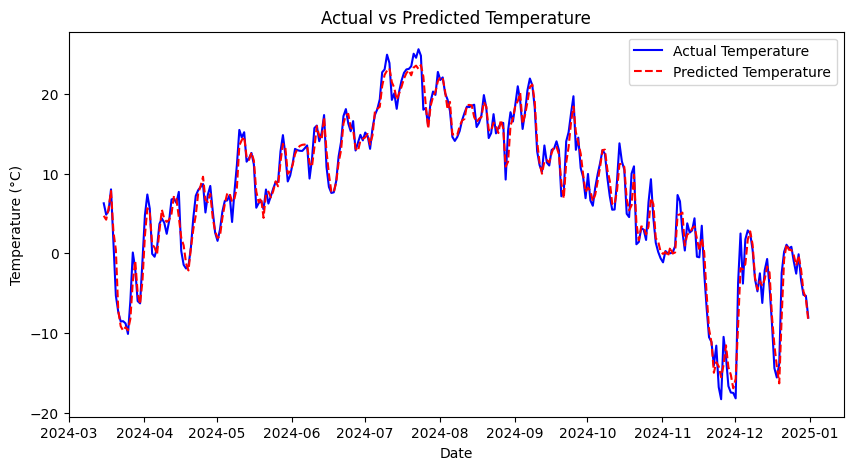

In [143]:
plt.plot(y_test.index, y_test, label="Actual Temperature", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Temperature", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.legend()
plt.show()

In [148]:
latest_Values = X.iloc[-1].values.reshape(1, -1)
future = model.predict(latest_Values)
print(future)

[-8.51464625]


C:\Users\khodg\OneDrive\Documents\Github\WeatherPred\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [160]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 51.0501,
	"longitude": -114.0853,
	"start_date": "2024-12-03",
	"end_date": "2024-12-31",
	"hourly": "soil_temperature_0_to_7cm",
	"daily": ["temperature_2m_mean", "daylight_duration", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_soil_temperature_0_to_7cm = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(3).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(4).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(5).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe2 = pd.DataFrame(data = daily_data)
print(daily_dataframe2)
df2 = daily_dataframe2.set_index("date")

Coordinates 51.07205581665039°N -114.03227233886719°E
Elevation 1043.0 m asl
Timezone b'America/Edmonton' b'GMT-7'
Timezone difference to GMT+0 -25200 s
                         date  soil_temperature_0_to_7cm
0   2024-12-03 07:00:00+00:00                     -0.601
1   2024-12-03 08:00:00+00:00                     -0.551
2   2024-12-03 09:00:00+00:00                     -0.551
3   2024-12-03 10:00:00+00:00                     -0.551
4   2024-12-03 11:00:00+00:00                     -0.501
..                        ...                        ...
691 2025-01-01 02:00:00+00:00                     -6.401
692 2025-01-01 03:00:00+00:00                     -6.601
693 2025-01-01 04:00:00+00:00                     -6.751
694 2025-01-01 05:00:00+00:00                     -6.951
695 2025-01-01 06:00:00+00:00                     -7.251

[696 rows x 2 columns]
                        date  temperature_2m_mean  daylight_duration  \
0  2024-12-03 07:00:00+00:00             2.474000       29402.13281

In [161]:
lags = 3  # Using past 3 days' data
for col in df2.columns:
    for lag in range(1, lags + 1):
        df2[f"{col}_Lag{lag}"] = df2[col].shift(lag)

# Moving Average Features
df2["Temp_MA_3"] = df2["temperature_2m_mean"].rolling(window=3).mean()
df2.dropna(inplace=True)
df2.head()

,temperature_2m_mean,daylight_duration,rain_sum,snowfall_sum,wind_speed_10m_max,shortwave_radiation_sum,temperature_2m_mean_Lag1,temperature_2m_mean_Lag2,temperature_2m_mean_Lag3,daylight_duration_Lag1,...,snowfall_sum_Lag1,snowfall_sum_Lag2,snowfall_sum_Lag3,wind_speed_10m_max_Lag1,wind_speed_10m_max_Lag2,wind_speed_10m_max_Lag3,shortwave_radiation_sum_Lag1,shortwave_radiation_sum_Lag2,shortwave_radiation_sum_Lag3,Temp_MA_3
date,,,,,,,,,,,,,,,,,,,,,
2024-12-06 07:00:00+00:00,2.861500,29109.396484,0.0,0.00,24.401787,3.65,1.740667,-3.813500,2.474000,29201.982422,...,0.00,0.00,0.0,23.924431,14.571108,26.406067,4.75,2.16,4.06,0.262889
2024-12-07 07:00:00+00:00,2.459417,29022.029297,0.2,0.00,17.581125,2.17,2.861500,1.740667,-3.813500,29109.396484,...,0.00,0.00,0.0,24.401787,23.924431,14.571108,3.65,4.75,2.16,2.353861
2024-12-08 07:00:00+00:00,0.394833,28940.072266,0.0,0.63,21.366234,2.34,2.459417,2.861500,1.740667,29022.029297,...,0.00,0.00,0.0,17.581125,24.401787,23.924431,2.17,3.65,4.75,1.905250
2024-12-09 07:00:00+00:00,-3.280167,28863.693359,0.0,0.00,14.941083,4.49,0.394833,2.459417,2.861500,28940.072266,...,0.63,0.00,0.0,21.366234,17.581125,24.401787,2.34,2.17,3.65,-0.141972
2024-12-10 07:00:00+00:00,-4.786417,28793.070312,0.0,0.07,12.749540,2.77,-3.280167,0.394833,2.459417,28863.693359,...,0.00,0.63,0.0,14.941083,21.366234,17.581125,4.49,2.34,2.17,-2.557250


In [162]:
X2 = df2.drop("temperature_2m_mean", axis = 'columns')

In [163]:
print(model.predict(X2.iloc[0].values.reshape(1, -1)))

[1.70668745]


C:\Users\khodg\OneDrive\Documents\Github\WeatherPred\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
